In [2]:
pwd

'/Users/kellymclean/diabetes_eye'

In [67]:
import json
import math
import os
import random
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm

import seaborn as sns

#style.use('fivethirtyeight')
#sns.set(style='whitegrid',color_codes=True)
from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *

%matplotlib inline

In [68]:
np.random.seed(42)

In [69]:
tf.random.set_seed(
    42
)

In [85]:
#train.csv is labelled to train images
#test.csv is labelled to test images
#Look at information in train and test .csv files
#5 categories:
#No_DR
#Mild
#Moderate
#Severe
#Proliferate_DR

In [86]:
#classes : 0 - No DR, 1 - Mild, 2 - Moderate, 3 - Severe, 4 - Proliferative DR
def classes_to_int(label):
    # label = classes.index(dir)
    label = label.strip()
    if label == "No DR":  return 0
    if label == "Mild":  return 1
    if label == "Moderate":  return 2
    if label == "Severe":  return 3
    if label == "Proliferative DR":  return 4
    print("Invalid Label", label)
    return 5

def int_to_classes(i):
    if i == 0: return "No DR"
    elif i == 1: return "Mild"
    elif i == 2: return "Moderate"
    elif i == 3: return "Severe"
    elif i == 4: return "Proliferative DR"
    print("Invalid class ", i)
    return "Invalid Class"

In [94]:
NUM_CLASSES = 5

In [95]:
train_path = '/Users/kellymclean/diabetes_eye/train/'
test_path = '/Users/kellymclean/diabetes_eye/test/'

In [96]:
train_df = pd.read_csv('/Users/kellymclean/diabetes_eye/train.csv')
print(train_df.head())

        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0


In [97]:
np.size(train_df)

7324

In [98]:
train_df.shape

(3662, 2)

In [99]:
x = train_df['id_code']
y = train_df['diagnosis']

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

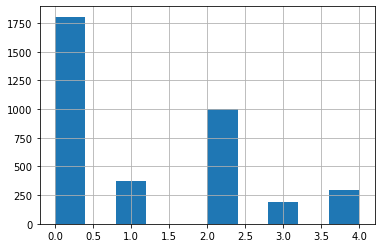

In [100]:
train_df['diagnosis'].hist()
train_df['diagnosis'].value_counts()

In [101]:
def get_label(diagnosis):
    return ','.join([str(i) for i in range(diagnosis + 1)])

In [102]:
train_df['label'] = train_df.diagnosis.apply(get_label)

In [103]:
train_df.head(10)

id_code  diagnosis      label
0  000c1434d8d7          2      0,1,2
1  001639a390f0          4  0,1,2,3,4
2  0024cdab0c1e          1        0,1
3  002c21358ce6          0          0
4  005b95c28852          0          0
5  0083ee8054ee          4  0,1,2,3,4
6  0097f532ac9f          0          0
7  00a8624548a9          2      0,1,2
8  00b74780d31d          2      0,1,2
9  00cb6555d108          1        0,1

In [80]:
# create image data bunch
data = ImageDataBunch.from_df('/',
                              df=df_train, 
                              valid_pct=0.2,
                              folder="Users/kellymclean/diabetes_eye/train",
                              suffix=".png",
                              ds_tfms=get_transforms(flip_vert=True, max_warp=0),
                              size=224,
                              bs=64, 
                              num_workers=0,
                             label_col='label', label_delim=',').normalize(imagenet_stats)

/Users/kellymclean/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/Users/kellymclean/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.

/Users/kellymclean/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/Users/kellymclean/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.

/Users/kellymclean/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/Users/kellymclean/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.

/Users/kellymclean/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/Users/kellymclean/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.

/Users/kellymclean/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [104]:
# check classes
print(f'Classes: \n {data.classes}')

Classes: 
 ['0', '1', '2', '3', '4']


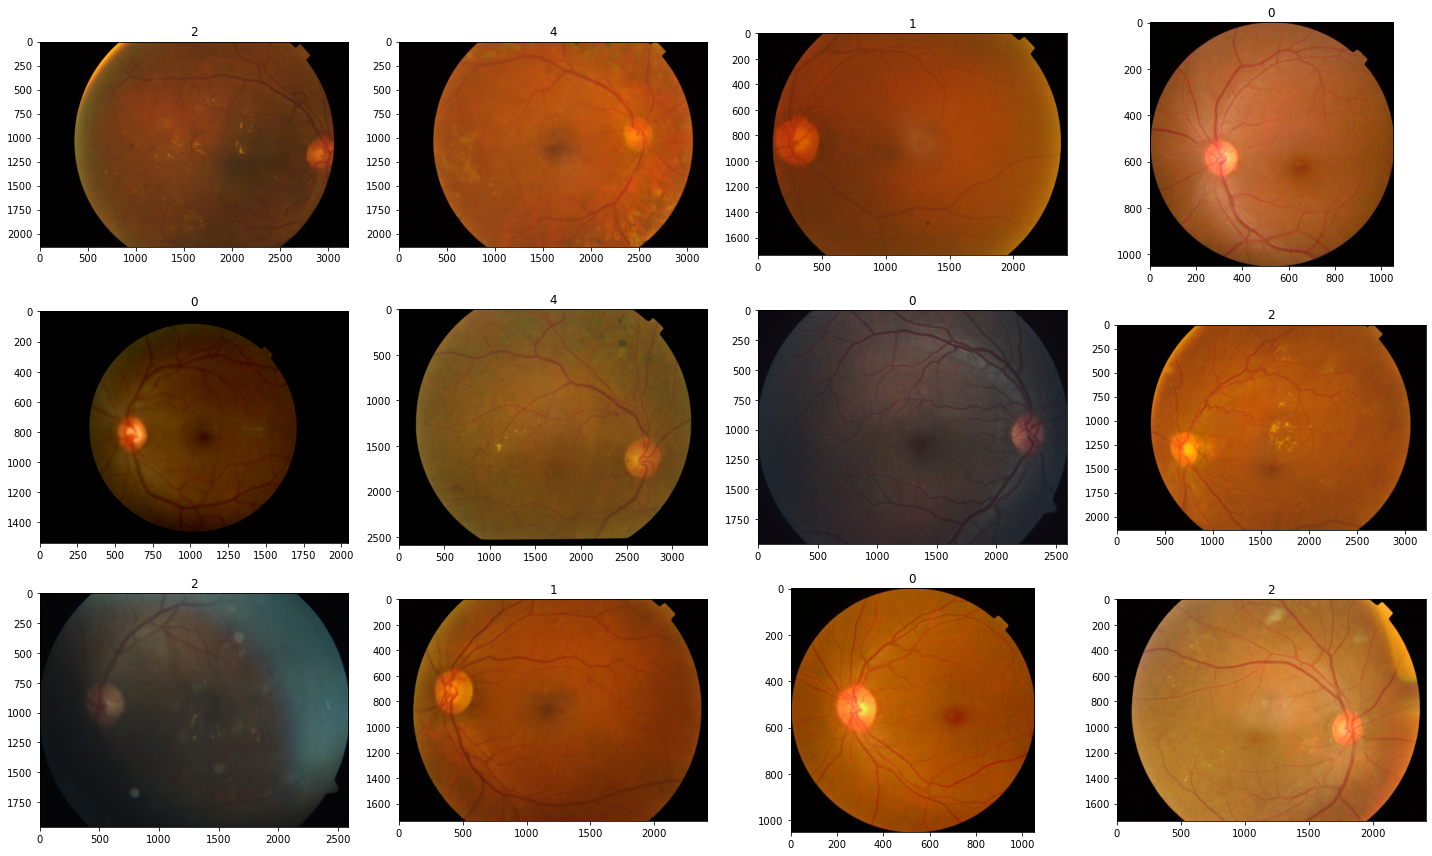

In [105]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'/Users/kellymclean/diabetes_eye/train/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

In [106]:
#resize images
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [107]:
test_df = pd.read_csv('/Users/kellymclean/diabetes_eye/test.csv')
print(test_df.head())

        id_code
0  0005cfc8afb6
1  003f0afdcd15
2  006efc72b638
3  00836aaacf06
4  009245722fa4


In [108]:
np.size(test_df)

1928

In [109]:
test_df.shape

(1928, 1)

train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=None)
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)
train_y.hist()
valid_y.hist()

#Need to create validation images
valid_x = images[-NUM_VAL_SAMPLES:]
valid_y = labels[-NUM_VAL_SAMPLES:]

In [110]:
# input image dimensions
IMG_SIZE = 224
img_rows = 224
img_cols = 224
img_channels = 3

%%time
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=None).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"/Users/kellymclean/diabetes_eye/train/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128) # the trick is to add this line

        plt.imshow(image, cmap='gray')
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

#Improve images via auto cropping
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def crop_image_from_gray(img,tol=7):
      
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = gray_img>tol        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img


def circle_crop(img):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    
    return img 


def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

plt.imshow(image)

%%time
## try circle crop
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(NUM_SAMP, random_state=None).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"/Users/kellymclean/diabetes_eye/train/{row['id_code']}.png"
        image = circle_crop(path)

        plt.imshow(image)
        
        ax.set_title('%d-%d-%s' % (class_id, idx, row['id_code']) )

def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [33]:
N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        f'/Users/kellymclean/diabetes_eye/train/{image_id}.png'
    )

100%|██████████| 3662/3662 [06:05<00:00, 10.03it/s]


In [34]:
N = test_df.shape[0]
x_test = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(
        f'/Users/kellymclean/diabetes_eye/test/{image_id}.png'
    )

100%|██████████| 1928/1928 [01:09<00:00, 27.57it/s]


In [35]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(3662, 224, 224, 3)
(3662, 5)
(1928, 224, 224, 3)


In [112]:
#Creating multilabels
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

print("Original y_train:", y_train.sum(axis=0))
print("Multilabel version:", y_train_multi.sum(axis=0))

Original y_train: [1519  320  850  169  254]
Multilabel version: [3112 1593 1273  423  254]


In [37]:
y_train_multi.shape

(3662, 5)

In [38]:
x_train.shape

(3662, 224, 224, 3)

In [39]:
#Now we can split it into a training and validation set.
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, 
    test_size=0.15, 
    random_state= 2019
)


#batch_size to train
BATCH_SIZE = 32
# number of output classes
nb_classes = 5
# number of epochs to train
nb_epoch = 5
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3
#(X, y) = (train_data[0],train_data[1])

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm

%matplotlib inline

In [41]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)

In [42]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('sept_model.h5')

        return Metrics

In [43]:
densenet = DenseNet121(
    weights= '/Users/kellymclean/diabetes_eye/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

In [44]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [45]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [47]:
kappa_metrics = Metrics()

In [48]:
history = model.fit_generator(
    data_generator,
    steps_per_epoch=32, #x_train.shape[0] / BATCH_SIZE,
    epochs=15,
    validation_data=(x_val, y_val)#,
    #callbacks=[kappa_metrics]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
32/32 [==============================] - 358s 11s/step - loss: 0.6724 - accuracy: 0.5240 - val_loss: 0.6639 - val_accuracy: 0.5582
Epoch 2/15
32/32 [==============================] - 2579s 81s/step - loss: 0.4174 - accuracy: 0.6572 - val_loss: 0.5688 - val_accuracy: 0.6018
Epoch 3/15
32/32 [==============================] - 980s 31s/step - loss: 0.3076 - accuracy: 0.7220 - val_loss: 0.4412 - val_accuracy: 0.6491
Epoch 4/15
32/32 [==============================] - 933s 29s/step - loss: 0.2810 - accuracy: 0.7390 - val_loss: 0.3682 - val_accuracy: 0.7036
Epoch 5/15
32/32 [==============================] - 881s 28s/step - loss: 0.2604 - accuracy: 0.7363 - val_loss: 0.2907 - val_accuracy: 0.7727
Epoch 6/15
32/32 [==============================] - 871s 27s/step - loss: 0.2510 - accuracy: 0.7617 - val_loss: 0.2200 - val_accuracy: 0.7873
Epoch 7/15
32/32 [==============================] - 871s 27s/step - los

In [49]:
model.save("model.h5")

#model with seed = 42 vs. 2020
history = model.fit_generator(
    data_generator,
    steps_per_epoch=32, #x_train.shape[0] / BATCH_SIZE,
    epochs=15,
    validation_data=(x_val, y_val),
    callbacks=[kappa_metrics]
)

In [50]:
# Display the training accuracy

model.evaluate(data_generator)

98/98 [==============================] - 667s 7s/step - loss: 0.1479 - accuracy: 0.8461


[0.14793196320533752, 0.8460797071456909]

In [51]:
import json

KeyError: "None of [Index(['acc', 'val_acc'], dtype='object')] are in the [columns]"

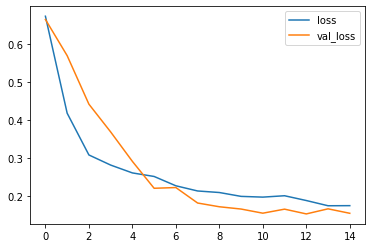

In [52]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

In [53]:
plt.plot(kappa_metrics.val_kappas)

AttributeError: 'Metrics' object has no attribute 'val_kappas'

from keras.models import load_model

model = load_model('model.h5')
y_test = []
y_actual = []

y_actual = np.array(y_actual)
y_test = np.array(y_test)

cm = confusion_matrix(y_actual, y_test)

#Plot the confusion matrix

sns.heatmap(cm, cmap = 'plasma', annot = True)
plt.show()

In [54]:
model.load_weights('model.h5')
y_val_pred = model.predict(x_val)

def compute_score_inv(threshold):
    y1 = y_val_pred > threshold
    y1 = y1.astype(int).sum(axis=1) - 1
    y2 = y_val.sum(axis=1) - 1
    score = cohen_kappa_score(y1, y2, weights='quadratic')
    
    return 1 - score

simplex = scipy.optimize.minimize(
    compute_score_inv, 0.5, method='nelder-mead'
)

best_threshold = simplex['x'][0]

In [56]:
y_test = model.predict(x_test) > 0.5
y_test = y_test.astype(int).sum(axis=1) - 1

test_df['diagnosis'] = y_test
test_df.to_csv('submission.csv',index=False)

In [57]:
df_submission = pd.read_csv('/Users/kellymclean/diabetes_eye/submission.csv')
print(df_submission.head(10))

        id_code  diagnosis
0  0005cfc8afb6         -1
1  003f0afdcd15         -1
2  006efc72b638          0
3  00836aaacf06          0
4  009245722fa4         -1
5  009c019a7309          0
6  010d915e229a         -1
7  0111b949947e          0
8  01499815e469          0
9  0167076e7089          0


In [58]:
x = df_submission['id_code']
y = df_submission['diagnosis']

 0    1467
-1     429
 1      32
Name: diagnosis, dtype: int64

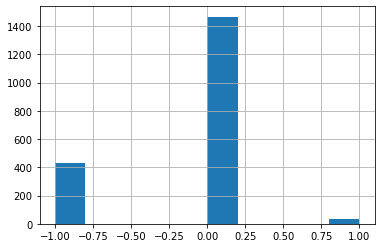

In [59]:
df_submission['diagnosis'].hist()
df_submission['diagnosis'].value_counts()

model = load_model('model.h5')
y_test = []
y_actual = []

model = Sequential()

model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        #border_mode='valid',
                        input_shape=(img_cols, img_rows, img_channels)))
convout1 = Activation('relu')
model.add(convout1)
model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
convout2 = Activation('relu')
model.add(convout2)
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta')#KERAS
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,Adam

model = Sequential()

model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        #border_mode='valid',
                        input_shape=(img_cols, img_rows, 1)))
convout1 = Activation('relu')
model.add(convout1)
model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
convout2 = Activation('relu')
model.add(convout2)
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [ ]:
model.summary()

In [66]:
#Augment the images of the training dataset 
train_datagen = image.ImageDataGenerator(
    rescale = 1./ 255,
    shear_range = 0.2,
    zoom_range = 0.2, 
    horizontal_flip = True)

# Resize to improve linearity of the test dataset 
test_datagen = image.ImageDataGenerator(rescale = 1. / 255)

NameError: name 'image' is not defined

In [65]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (img_rows, img_cols), 
    batch_size = BATCH_SIZE, 
    class_mode = 'categorical',
    classes={'No_DR': 0,
             'Mild' : 1,
             'Moderate' : 2,
             'Severe' : 3,
             'Proliferate_D' : 4},
    subset = 'training')

train_generator.class_indices

NameError: name 'train_datagen' is not defined

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = (img_rows, img_cols),
    batch_size = BATCH_SIZE, 
    class_mode = 'categorical',
    classes={'No_DR': 0,
             'Mild' : 1,
             'Moderate' : 2,
             'Severe' : 3,
             'Proliferate_D' : 4},
    subset = 'training'
)

test_generator.class_indices

In [ ]:
val_generator = datagen.flow_from_directory(
    val_path, 
    target_size=(img_rows, img_cols), 
    batch_size=BATCH_SIZE,
    class_mode = 'categorical',
    classes={'No_DR': 0,
             'Mild' : 1,
             'Moderate' : 2,
             'Severe' : 3,
             'Proliferate_D' : 4},
    subset = 'training'
)

val_generator.class_indices

In [ ]:
#Fit Model
Model.fit(train_generator, 
                    steps_per_epoch = 8, 
                    epochs = 10, 
                    validation_data = test_generator, 
                    validation_steps = 2,
                    verbose = 1)

In [ ]:
image_folder = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_D']


for i in image_folder:
    sample_images = list(pathlib.Path('../dataset/'+i+'/').rglob('*/'))
    np.random.seed(42)
    rand_imgs = np.random.choice(sample_images, size=10*10)

    shapes = []
    for img in rand_imgs:
        shapes.append(imread(str(img)).shape)
    
    shapes = pd.DataFrame().assign(X=pd.Series(shapes).map(lambda s: s[0]), Y=pd.Series(shapes).map(lambda s: s[1]))
    
    plt.figure(figsize=(12, 8))
    sns.set_context("notebook", font_scale=1.5)
    sns.kdeplot(shapes['X'], bw=75)
    sns.kdeplot(shapes['Y'], bw=75)
    plt.title('Distribution of {}_image Sizes'.format(i))
    ax = plt.gca()
    ax.set_xlim(0, ax.get_xlim()[1])

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [ ]:
estimator = KerasClassifier(build_fn=model, epochs=200, batch_size=5, verbose=0)

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)

In [ ]:
results = cross_val_score(estimator, X, dummy_y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
def get_preds_and_labels(model, generator):
    """
    Get predictions and labels from the generator
    
    :param model: A Keras model object
    :param generator: A Keras ImageDataGenerator object
    
    :return: A tuple with two Numpy Arrays. One containing the predictions
    and one containing the labels
    """
    preds = []
    labels = []
    for _ in range(int(np.ceil(generator.samples / BATCH_SIZE))):
        x, y = next(generator)
        preds.append(model.predict(x))
        labels.append(y)
    # Flatten list of numpy arrays
    return np.concatenate(preds).ravel(), np.concatenate(labels).ravel()

In [ ]:
# Save the model 

model.save("aug_model.h5")

In [ ]:
# Display the training accuracy

model.evaluate_generator(train_generator)

In [ ]:
#Dispay the validation accuracy 

model.evaluate_generator(test_generator)

In [ ]:
model = load_model('aug_model.h5')
y_test = []
y_actual = []

In [ ]:
for i in os.listdir("/Users/kellymclean/diabetes_eye/test"):
    img = image.load_img("/Users/kellymclean/diabetes_eye/test" + i, target_size = (200, 200))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    p = model.predict_classes(img)
    y_test.append(p[0, 0])
    y_actual.append(1)
 

In [ ]:
    
for i in os.listdir("/Users/kellymclean/August14_Covid/Dataset/Test Data/Covid/"):
    img = image.load_img("/Users/kellymclean/August14_Covid/Dataset/Test Data/Covid/" + i, target_size = (224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    p = model.predict_classes(img)
    y_test.append(p[0, 0])
    y_actual.append(0)

In [ ]:
y_actual = np.array(y_actual)
y_test = np.array(y_test)

In [ ]:
cm = confusion_matrix(y_actual, y_test)

In [ ]:
#Plot the confusion matrix

sns.heatmap(cm, cmap = 'plasma', annot = True)
plt.show()

from skimage import color
from skimage import io

img = color.rgb2gray(io.imread('/Users/kellymclean/diabetes_eye/train/000c1434d8d7.png'))

import skimage.viewer
# display image
viewer = skimage.viewer.ImageViewer(img)
viewer.show()

#import libraries
from scipy import misc
from PIL import Image
from skimage import exposure
from sklearn import svm

import scipy
from math import sqrt,pi
from numpy import exp
from matplotlib import pyplot as plt
import numpy as np
import glob
import matplotlib.pyplot as pltss
import cv2
from matplotlib import cm
import pandas as pd
from math import pi, sqrt
import pywt

In [ ]:
np.shape(np.array(equ).flatten())

In [ ]:
#random images shape and flattened
np.shape(immatrix)
np.shape(equ)
plt.imshow(immatrix[78].reshape((1152,1500)),cmap='gray')
plt.show()